In [42]:
# Import required libraries and modules
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dateparser import parse
import pandas as pd
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmcrameri.cm as cmc
import os
from matplotlib.dates import DayLocator, DateFormatter, HourLocator
from matplotlib import gridspec
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use("project.mplstyle")

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask

cluster = SLURMCluster(cores=1, memory="5GB", walltime='10:00:00')
cluster.scale(jobs=50)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.0.0.16:8787/status,
Dashboard: http://10.0.0.16:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.0.16:42571,Workers: 0
Dashboard: http://10.0.0.16:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# Load the bathymetry dataset
bat = xr.open_dataset("../data/gebco_2022_n21.4673_s-7.4048_w-68.6426_e-32.7393.nc").elevation
# Select specific latitude and longitude slices
bat = bat.sel(lat=slice(-7.5, 15, 10), lon=slice(-66, -30, 10))

# Load the HYCOM dataset
hycom = xr.open_dataset("../data/HYCOM/GLBy008expt_93.nc")
# Rename variables in the dataset
hycom = hycom.rename(water_u="u", water_v="v")
# Calculate speed and rename coordinates
hycom = hycom.assign(spd=np.sqrt(hycom.u**2 + hycom.v**2)).rename(lon="longitude", lat="latitude")

# Load the OSCAR dataset in parallel
oscar = xr.open_mfdataset("../data/OSCAR_L4_OC_NRT_V2.0/*.nc", parallel=True)
# Adjust time and longitude coordinates
oscar = oscar.assign_coords(time=[parse(time.strftime()) for time in oscar.time.values])
oscar = oscar.assign_coords(lon=(((oscar.lon + 180) % 360) - 180))
oscar = oscar.rename(lon="longitude", lat="latitude")
oscar = oscar.assign_coords(longitude=oscar.longitude, latitude=oscar.latitude)
# Select specific variables and coordinates, then transpose the data
oscar = oscar[["u", "v"]].sel(latitude=slice(-7.4, 15), longitude=slice(-66, -30))
oscar = oscar.transpose("latitude", "longitude", "time")
# Calculate speed for oscar dataset
oscar = oscar.assign(spd=np.sqrt(oscar.u**2 + oscar.v**2))
oscar = oscar.load()

# Loop to load GLORYS dataset for specific months and append them to a list
glorys_all = []
for mo in [7, 8, 9]:
    glorys = xr.open_dataset(f"../data/GLORYS/GLOBAL_ANALYSISFORECAST_PHY_001_024-TDS_2022_{mo:02.0f}.nc")
    glorys = glorys.rename(utotal="u", vtotal="v").squeeze()
    glorys = glorys.assign(spd=np.sqrt(glorys.u**2 + glorys.v**2))
    glorys_all.append(glorys)
# Concatenate all monthly datasets into one
glorys = xr.concat(glorys_all, "time")

# Load the TICO dataset
tico = xr.open_dataset("../data/tico_data_filtered.nc")

/tmp/ipykernel_3059249/4202203452.py:18: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  oscar = oscar.rename(lon="longitude", lat="latitude")
/tmp/ipykernel_3059249/4202203452.py:18: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  oscar = oscar.rename(lon="longitude", lat="latitude")


In [6]:
# Define a function to smooth the datasets
def smooth(ds, window = tico.hanning_window):
    """Smooth the dataset over the time dimension using a Hanning window."""
    
    # Create a weighted Hanning window
    weight = xr.DataArray(np.hanning(window), dims=['window'])

    for k in ["spd", "u", "v"]:
        # Interpolate missing values in time and apply rolling window averaging
        ds[k] = ds[k].interpolate_na("time").rolling(
            time=window, center=True, min_periods=1
        ).construct('window').dot(weight) / weight.sum()
    return ds

# Interpolate and smooth the GLORYS dataset based on TICO coordinates
glorysi = smooth(glorys.interp(
    longitude=tico.longitude, latitude=tico.latitude, time=tico.time
))

# Interpolate and smooth the HYCOM dataset based on TICO coordinates
hycomi = smooth(hycom.interp(
    longitude=tico.longitude, latitude=tico.latitude, time=tico.time
))

# Interpolate and smooth the OSCAR dataset based on TICO coordinates
oscari = smooth(oscar.interp(
    longitude=tico.longitude, latitude=tico.latitude, time=tico.time
))

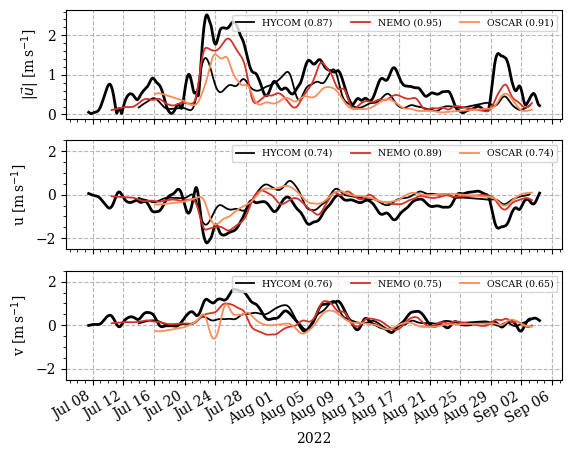

In [43]:
# Define a lambda function for the correlation coefficient calculation
R = lambda x, y, d="time": ((x * y).sum(d) / (np.sqrt((x**2).sum(d)) * np.sqrt((y**2).sum(d)))).values

# Format for the date in the x-axis
fmt = "%b %d"

# Create subplots
fig, ax = plt.subplots(3, 1)

# Loop through axes and variables to plot
for a, k in zip(ax, ["spd", "u", "v"]):
    # Plot the TICO dataset
    tico[k].plot(ax=a, color="k")
    # Plot the interpolated and smoothed datasets, adding the correlation coefficient to the label
    hycomi[k].plot(ax=a, label=f"HYCOM ({R(tico[k], hycomi[k]):.2f})", lw=1.3)
    glorysi[k].plot(ax=a, label=f"NEMO ({R(tico[k], glorysi[k]):.2f})", lw=1.3)
    oscari[k].plot(ax=a, label=f"OSCAR ({R(tico[k], oscari[k]):.2f})", lw=1.3)
    # Set legend properties
    a.legend(ncol=3, fontsize=6.8, loc=1)
    
    # Adjust y-limits for u and v components
    if k != "spd":
        a.set(ylim=[-2.5, 2.5])
    
    # Set x-axis properties
    a.xaxis.set_major_locator(DayLocator(interval=4))
    a.xaxis.set_major_formatter(DateFormatter(fmt))
    # Add grid to the subplot
    a.grid(True, linestyle="--", alpha=0.9)

# Set labels for each subplot
ax[0].set(ylabel="|$\\vec{{u}}$| [m$\,$s$^{-1}$]", xticklabels=[], xlabel="")
ax[1].set(ylabel="u [m$\,$s$^{-1}$]", xticklabels=[], xlabel="")
ax[2].set(ylabel="v [m$\,$s$^{-1}$]", xlabel="2022")

# Save the figure to a file
fig.savefig("../img/comparing_products.png", dpi=300, facecolor="w", bbox_inches="tight")

# Static plot for the paper

In [28]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

In [15]:
weight = xr.DataArray(np.hanning(tico.hanning_window), dims=['window'])
def smooth(ds, window = tico.hanning_window):
    for k in ["spd","u","v"]:
        ds[k] = ds[k].interpolate_na("time").rolling(time=window,center=True,min_periods=1).construct('window').dot(weight)/weight.sum()
    return ds

model = smooth(glorys.sel(time=slice(tico.time.min(),tico.time.max())).resample(time=tico.time_interval).mean()).bfill("time")
modeli = glorysi

In [17]:
# load SMAP Sea Surface Salinity data
sss = xr.open_mfdataset("../data/SMAP/*")["smap_sss"].sortby("latitude")
sss = sss.sel(latitude=slice(-7.4,15), longitude=slice(-66,-30)).load().interpolate_na("time")

In [19]:
rain = (
    xr.open_mfdataset("../data/IMERG/*")["precipitationCal"]
    .rename(lon="longitude", lat="latitude")
    .sel(latitude=slice(-7.4,15), longitude=slice(-68,-29))
).load().T#.rolling(longitude=10,latitude=10,center=True).mean()

time = [datetime(y,m,d) for y,m,d in zip(rain.time.dt.year,rain.time.dt.month,rain.time.dt.day)]
rain = rain.assign_coords(time=time)

/tmp/ipykernel_3059249/3972876975.py:7: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  time = [datetime(y,m,d) for y,m,d in zip(rain.time.dt.year,rain.time.dt.month,rain.time.dt.day)]


In [22]:
# interp bathymetry
tico = tico.assign(local_depth = bat.interp(lat = tico.latitude, lon = tico.longitude).drop(["lat","lon"]))

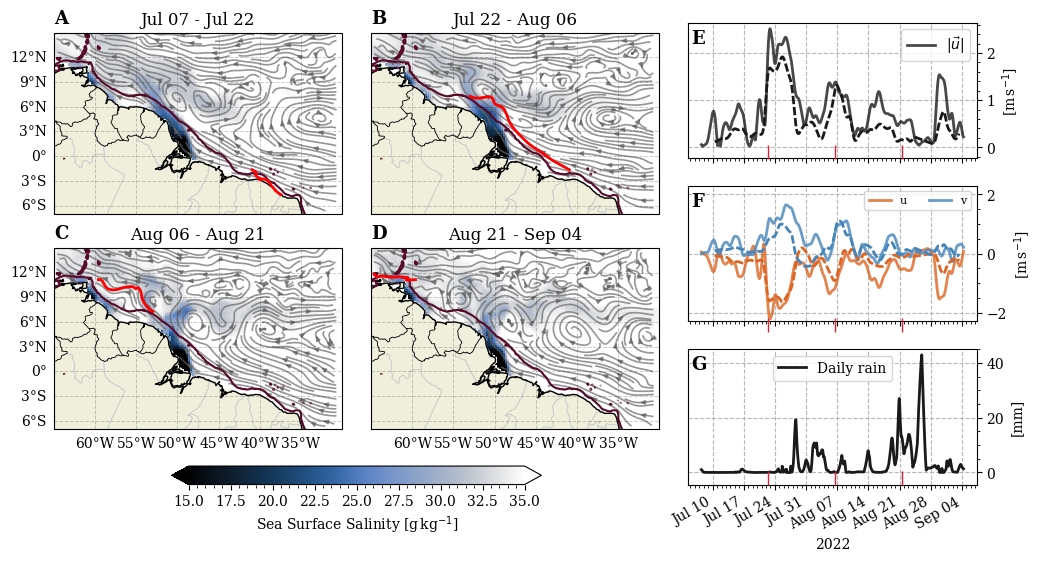

In [45]:
proj = projection = ccrs.PlateCarree()

timei = pd.date_range(start=tico.time.min().values, end=tico.time.max().values, freq="1d")[::15]

lablat = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$N' if lat>0 else f'{-lat}$^\\circ$S'
lablon = lambda lat: f'{lat}$^\\circ$' if lat==0 else f'{lat}$^\\circ$E' if lat>0 else f'{-lat}$^\\circ$W'

xticks = np.arange(-180,180,5)
yticks = np.arange(-90,90,5)

kw = dict(
    sss = dict(x="longitude",y="latitude",cmap=cmc.oslo,vmin=15,vmax=35, transform=proj,add_colorbar=False),
    oscar = dict(x="longitude",y="latitude",u="u",v="v", color=(0.4,0.4,0.4,0.7), density=1.8, transform=proj,linewidth=1.2,arrowsize=0.6),
)

fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(hspace=0.5,wspace=0.1)
gs = gridspec.GridSpec(6, 4)

ax = [
    fig.add_subplot(gs[:3,0],projection=proj),
    fig.add_subplot(gs[:3,1],projection=proj),
    fig.add_subplot(gs[3:,0],projection=proj),
    fig.add_subplot(gs[3:,1],projection=proj)
]

for a, label in zip(ax,('A', 'B', 'C', 'D')):
    a.text(0, 1.03, label, transform=a.transAxes,
      fontsize=13, fontweight='bold', va='bottom', ha='left')


ax = np.ravel(ax)
dtmax = pd.to_datetime(str(tico.time.max().values)).strftime('%Y-%m-%d %H:%M:%S')
i = 0
for ti,tj,a in zip(timei.tolist(), timei[1:].tolist()+[dtmax], ax):
    # if i==1:
    #     break
    # i=i+1
    a.add_feature(land_10m)
    a.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='0.8')
    a.add_feature(cfeature.BORDERS, linewidth=0.6, edgecolor='black')
    a.coastlines()
    a.plot(tico.sel(time=slice(ti,tj)).longitude,tico.sel(time=slice(ti,tj)).latitude,color="red",zorder=1e2)
    C = sss.sel(time=slice(ti,tj)).mean("time").plot(ax=a,**kw["sss"])
    # sss.sel(time=slice(ti,tj)).mean("time").plot.contour(ax=a,levels=[10,25],colors=["0.2"],transform=proj)
    model.sel(time=slice(ti,tj),longitude=slice(-65,-30),latitude=slice(-7,15)).mean("time").plot.streamplot(ax=a,**kw["oscar"])    
    # rain.sel(time=slice(ti,tj)).sum("time").plot.contour(ax=a,**kw["rain"])
    bat.plot.contour(ax=a,levels=[-200],linestyles="-",transform=proj,colors="#580a2b",linewidths=1.5)
    
    a.set_extent([-65,-30,-7,15],crs=proj)
    a.set_title(pd.to_datetime(ti).strftime("%b %d")+" - "+pd.to_datetime(tj).strftime("%b %d"))

gl = []
for a in ax:
    gl.append(a.gridlines(draw_labels=True, linewidth=0.7, color='black', alpha=0.2, linestyle='--'))
gl = np.array(gl)
    
for gli in gl:
    gli.top_labels = False
    gli.right_labels = False
for gli in gl[[0,1]]:
    gli.bottom_labels = False
for gli in gl[[1,3]]:
    gli.left_labels = False
    
fig.colorbar(C,ax=ax,
             label="Sea Surface Salinity [g$\,$kg$^{-1}$]",
             orientation="horizontal",extend="both",fraction=0.04,pad=0.08
             
)


ax = [
    fig.add_subplot(gs[:2,2]),
    fig.add_subplot(gs[2:4,2]),
    fig.add_subplot(gs[4:,2]),
]


for a, label in zip(ax,('E', 'F', 'G')):
    a.text(0.01, 0.95, label, transform=a.transAxes,
      fontsize=13, fontweight='bold', va='top', ha='left')

R = lambda x,y,d="time": ((x*y).sum(d)/(np.sqrt((x**2).sum(d))*np.sqrt((y**2).sum(d)))).values

raini = rain.interp(longitude=tico.longitude,latitude=tico.latitude,time=tico.time)

fmt = "%b %d"

tico.spd.plot(label=f"|$\\vec{{u}}$|",ax=ax[0],color="0.1",alpha=0.8)
modeli.spd.plot(ax=ax[0],color="0.1",linestyle=(0,(3,1)),lw=2)

tico.u.plot(label=f"u",ax=ax[1],color="#dd6422",alpha=0.8)
tico.v.plot(label=f"v",ax=ax[1],color="#4485bb",alpha=0.8)

modeli.u.plot(ax=ax[1],color="#dd6422",linestyle=(0,(3,1)),lw=2)
modeli.v.plot(ax=ax[1],color="#4485bb",linestyle=(0,(3,1)),lw=2)

raini.plot(ax=ax[2],color="0.1",label="Daily rain")

ax[0].legend(loc=1)
ax[1].legend(ncol=2,loc=1,fontsize=8)
ax[2].legend(loc="upper center")

for a in ax:
    # _ = [a.axvline(t,linestyle="-",alpha=0.4) for t in timei[1:]]
    ylim = a.get_ylim()
    a.plot(timei[1:],[ylim[0]]*timei[1:].size,
           marker="|",lw=0,color="#de2135",
           clip_on=False,zorder=1e4, markersize=10,
    )
    a.yaxis.set_label_position("right")
    a.yaxis.tick_right()
    a.xaxis.set_minor_locator(DayLocator(interval=1))
    a.xaxis.set_major_locator(DayLocator(interval=7))
    a.xaxis.set_major_formatter(DateFormatter(fmt))
    
ax[0].set(title="",xlabel="",xticklabels=[],ylabel="[m$\,$s$^{-1}$]")
ax[1].set(title="",ylim=[-2.3,2.3],xlabel="",xticklabels=[],ylabel="[m$\,$s$^{-1}$]")
ax[2].set(xlabel="2022",ylabel="[mm]")


fig.savefig("../img/sss_currents_rain.png", dpi=300, facecolor="w")

# Video

In [46]:
def integrate(field, dt=3600, nparticles=1000, update_dist=100, quantile=0.1):
    
    xinit,yinit = np.meshgrid(np.arange(-65,-30, 0.1), np.arange(-6,15, 0.1))

    xinit, yinit = xinit.ravel(), yinit.ravel()

    field_i = field.u.isel(time=0).interp(longitude=("particles",xinit), latitude=("particles",yinit)).dropna("particles")

    xinit, yinit = field_i.longitude.values, field_i.latitude.values

    ind = np.random.randint(0,xinit.size,nparticles)
    xi, yi = xinit[ind], yinit[ind]

    x = []
    y = []

    times = pd.date_range(start=field.time.min().values, end=field.time.max().values, freq=f"{dt}s").values
    i = 0
    for timei in tqdm(times):
        dxdy = field.sel(time=timei,method="nearest").interp(longitude=("particle",xi),latitude=("particle",yi))*dt
        xi = (xi+dxdy.u).values
        yi = (yi+dxdy.v).values
        x.append(xi.copy())
        y.append(yi.copy())

        nans = np.isnan(xi)
        if nans.sum()>0:
            ind = np.random.randint(0,int(xinit.size*quantile),nans.sum())
            xi[nans], yi[nans] = xinit[ind], yinit[ind]

        if i%update_dist==0:
            dist = np.array([np.nanmin(np.sqrt((xii-xi)**2+(yii-yi)**2)) for xii,yii in zip(xinit,yinit)])
            ind = np.argsort(dist)[::-1]
            xinit, yinit = xinit[ind], yinit[ind]
        i = i+1
        
        
    x = np.vstack(x)
    y = np.vstack(y)

    x = xr.DataArray(x,dims=["time","particles"],
             coords=dict(
                 time=("time",times),
                 particles=("particles",np.arange(nparticles))
             ),name="x")
    y = xr.DataArray(y,dims=["time","particles"],
             coords=dict(
                 time=("time",times),
                 particles=("particles",np.arange(nparticles))
             ),name="y")

    output = xr.merge([x,y])
    
    return output

In [48]:
modeli = model[["u","v"]].sel(time=slice("2022-07-06","2022-09-05"))/112e3 # rough approximation for degrees/s
# valid = ~np.isnan(modeli)
# modeli = modeli.where(bat.interp(lon=modeli.longitude,lat=modeli.latitude)<-200)

In [49]:
nparticles=3000
dt = 3600
quantile = 0.08
particles = integrate(modeli, dt=dt, nparticles=nparticles, quantile=quantile)

100%|██████████| 1414/1414 [03:20<00:00,  7.06it/s]


In [50]:
ti = particles.time.values[800]
dsi = tico.sel(time=slice(ti-np.timedelta64(5,"D"),ti))
particles_i = particles.sel(time=slice(ti-np.timedelta64(5,"D"),ti)).dropna("particles",how="all")


/autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/coringa/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


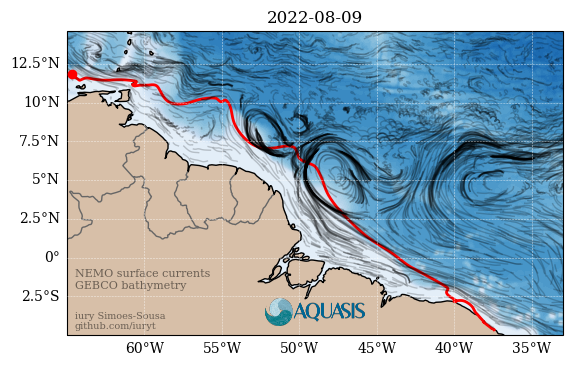

In [52]:
projection = ccrs.PlateCarree()

im = plt.imread("../img/nova-logo-aquasis-digital.png")

fig = plt.figure()
ax = fig.add_subplot(projection=projection)
bat.rolling(lon=5,lat=5).mean().plot.contourf(ax=ax,transform=projection,levels=50, vmin=-8000, vmax=800, cmap="Blues_r", extend="max", add_colorbar=False)
ax.add_feature(cfeature.LAND, facecolor="#d7bfa8",zorder=1)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, color="0.4")
ax.gridlines(draw_labels=["left","bottom"],linewidth=0.4,linestyle="--",transform=projection,zorder=1e4,color="w",alpha=0.7)
_ = ax.plot(particles_i.x,particles_i.y,color="0.0",lw=1,alpha=0.2,zorder=1e3,transform=projection)
if tico.longitude.size>2:
    ax.plot(tico.longitude, tico.latitude,color="red")
    ax.scatter(tico.longitude.values[-1], tico.latitude.values[-1],color="red",zorder=1e3,transform=projection)
ax.set(extent=[-65,-33,-5,14.5])
ax.set_title(f"{np.datetime_as_string(particles_i.time.max(),unit='D')}")
ax.text(-64.5,-2,"NEMO surface currents\nGEBCO bathymetry",fontsize=8,alpha=0.5)
ax.text(-64.5,-4.6,"iury Simoes-Sousa\ngithub.com/iuryt",fontsize=7,alpha=0.5)

inset_axes = ax.inset_axes([0.4, 0, 0.2, 0.15],zorder=1e10)
inset_axes.imshow(im,zorder=1e10)
inset_axes.axis('off')
inset_axes.set_facecolor("#d7bfa8")
fig.savefig(f"../img/test.png", dpi=300)

In [53]:
@dask.delayed
def frame(particles_i,dsi,frame=0):
    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(projection=projection)
    bat.rolling(lon=5,lat=5).mean().plot.contourf(ax=ax,transform=projection,levels=50, vmin=-8000, vmax=800, cmap="Blues_r", extend="max", add_colorbar=False)
    ax.add_feature(cfeature.LAND, facecolor="#d7bfa8",zorder=1)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, color="0.4")
    ax.gridlines(draw_labels=["left","bottom"],linewidth=0.4,linestyle="--",transform=projection)
    _ = ax.plot(particles_i.x,particles_i.y,color="0.0",lw=1,alpha=0.2,zorder=1e3,transform=projection)
    if dsi.longitude.size>2:
        ax.plot(dsi.longitude, dsi.latitude,color="red")
        ax.scatter(dsi.longitude.values[-1], dsi.latitude.values[-1],color="red",zorder=1e3,transform=projection)
    ax.set(extent=[-65,-33,-5,14.5])
    ax.set_title(f"{np.datetime_as_string(particles_i.time.max(),unit='D')}")
    ax.text(-64.5,-2,"NEMO surface currents\nGEBCO bathymetry",fontsize=8,alpha=0.5)
    ax.text(-64.5,-4.6,"iury Simoes-Sousa\ngithub.com/iuryt",fontsize=7,alpha=0.5)
    
    im = plt.imread("../img/nova-logo-aquasis-digital.png")
    inset_axes = ax.inset_axes([0.4, 0, 0.2, 0.15],zorder=1e10)
    inset_axes.imshow(im,zorder=1e10)
    inset_axes.axis('off')
    inset_axes.set_facecolor("#d7bfa8")
    fig.savefig(f"../img/video/{frame:04d}.png", dpi=400)
    plt.close("all")

In [54]:
objs = [frame(particles.sel(time=slice(ti-np.timedelta64(5,"D"),ti)).dropna("particles",how="all"),tico.sel(time=slice(ti-np.timedelta64(5,"D"),ti)),i) for i,ti in enumerate(tqdm(particles.time.values))]

100%|██████████| 1414/1414 [00:42<00:00, 33.39it/s]


In [ ]:
R = dask.compute(*objs)

/autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/coringa/lib/python3.9/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 5.57 MiB detected in task graph: 
  (<xarray.Dataset>
Dimensions:    (time: 121, parti ...       1H, 1413)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


In [ ]:
os.system("ffmpeg -y -framerate 40 -pattern_type glob -i '../img/video/*.png' -c:v libx264 -preset veryslow -crf 0 -pix_fmt yuv420p ../img/output.mp4")